In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)
import os
import json
from tqdm import tqdm
import random
from scipy.special import expit

15:14:02 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\dimot\.cmdstan\RTools40


CmdStan install directory: C:\Users\dimot\.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


In [2]:
op_sample = pd.read_csv("data/instacart/order_product_sample.csv")
o_sample = pd.read_csv("data/instacart/orders_sample.csv")
p_sample = pd.read_csv("data/instacart/products_sample.csv")
op_sample = op_sample.merge(p_sample[["product_id", "aisle_id"]])
with open('data/instacart/test_orders.json') as json_file:
    test_orders = json.load(json_file)
with open('stan_models/IC_GP_data.json') as json_file:
    gp_data = json.load(json_file)
with open('stan_models/instacart_data.json') as json_file:
    logit_data = json.load(json_file)

with open('data/instacart/products.json') as json_file:
    products = json.load(json_file)
products = {int(key):products[key] for key in products.keys()}

with open('data/instacart/orders_attr.json') as json_file:
    orders_attr = json.load(json_file)

with open('data/instacart/orders_nodes.json') as json_file:
    orders_nodes = json.load(json_file)

print(test_orders)

[142, 169, 4, 39, 138, 22, 31, 163, 154, 18]


In [3]:
fit_logit = cmdstanpy.from_csv("stan_models/fitted_logit")
logit_gibbs = cmdstanpy.CmdStanModel(stan_file='stan_models/logit_gibbs.stan', force_compile=True
                                             )

15:14:52 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_gibbs.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_gibbs.exe
15:15:08 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_gibbs.exe


In [9]:
# Obtenemos las características del delito / compra
the_test_order = test_orders[0]
test_order = o_sample[o_sample["order_id"]==the_test_order]
crime_type = test_order.user_id.values[0]
z_j = test_order[["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "pm"]].values[0]

# Definimos el grupo inicial
group = [1,4,7]
n_attr = len(list(products[next(iter(products))].values())) # Anotamos la cantidad de atributos de un sujeto para cuando el grupo sea vacío.

# Definimos las características del grupo inicial
group_features = {p:products[p] for p in group}
if len(group_features) != 0:
   group_features_matrix = [list(value.values()) for key, value in group_features.items()]
else:
   group_features_matrix = [n_attr * [0]]

q = np.array(list(group_features_matrix))
q = np.dot(np.ones(len(q)), q)

N_iter = 50000

samples = []
n_muestras = len(fit_logit.stan_variables()[next(iter(fit_logit.stan_variables()))])

i_index = list(products.keys())
I = len(products)

all_gammas = fit_logit.stan_variables()["gamma"]
all_betas = fit_logit.stan_variables()["beta"]
all_lambdas = fit_logit.stan_variables()["lambda"]

for n in tqdm(range(N_iter)):
   sample = random.sample(range(n_muestras), 1)[0]

   gamma = all_gammas[sample]
   betas = all_betas[sample]
   lambdas = all_lambdas[sample]

   i_order = random.sample(i_index, I)

   for s in i_order:
      change_flag = False
      u_i = np.array(list(products[s].values()))
      beta = betas[s-1]
      lambd = lambdas[s-1]

      node_propension = np.dot(u_i, gamma)
      link_preference = np.dot(z_j, beta)
      group_preference = np.dot(q, lambd)
      util = node_propension + link_preference + group_preference
      p = expit(util)
      
      if (random.random() < p):
         if (s not in group): # si el resultado es positivo, y no está en el grupo
            group.append(s)
            change_flag = True
      else:
         if s in group:
            group.remove(s)
            change_flag = True

      if change_flag: # Si cambió un miembro del grupo, tenemos que recalcular q
         group_features = {p:products[p] for p in group}
         if len(group_features) != 0:
            group_features_matrix = [list(value.values()) for key, value in group_features.items()]
         else:
            group_features_matrix = [n_attr * [0]]

         q = np.array(list(group_features_matrix))
         q = np.dot(np.ones(len(q)), q)

   # Terminamos la iteración por los sujetos de la red
   if n > 3000:
      samples.append(group.copy())



      

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [02:26<00:00, 340.52it/s]


In [10]:
samples_str = [str(sample) for sample in samples]
samples_df = pd.DataFrame()
samples_df["sample"] = samples_str

<Axes: ylabel='Count'>

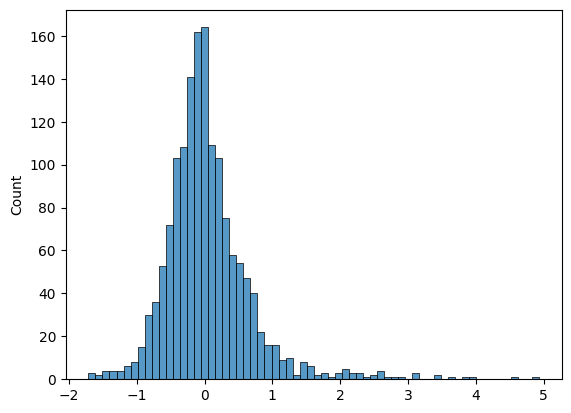

In [11]:
# Vemos el interés de los sujetos por las características del grupo
# Aquí espero que haya valores positivos y negativos, para que haya discriminación sobre los grupos.
mean_lambdas = []
all_lambdas = fit_logit.stan_variables()["lambda"]
for i in range(len(all_lambdas.T)):
    l_out = all_lambdas.T[i]
    for j in range(len(l_out)):
        l_in = l_out[j]
        mean_lambdas.append(l_in.mean())

sns.histplot(mean_lambdas)

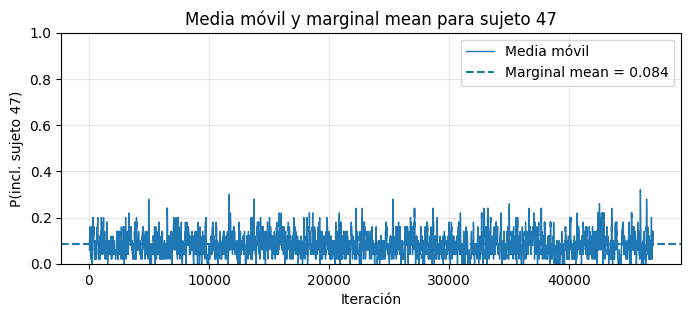

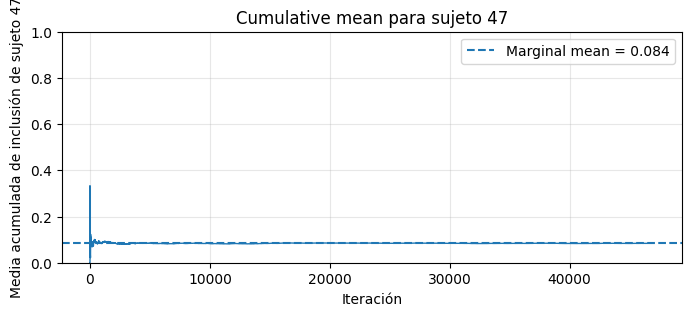

In [12]:
import numpy as np
import matplotlib.pyplot as plt

pos = {s: idx for idx, s in enumerate(i_index)}

# 2) Creamos la matriz binaria: rows=iter, cols=subjects
trace = np.zeros((len(samples), len(i_index)), dtype=int)

for t, grp in enumerate(samples):
    for s in grp:
        trace[t, pos[s]] = 1

# 3) Selecciona los sujetos que quieras plotear
# Por ejemplo, primeros 3:
subjects_to_plot = [47]

window = 50   # tamaño de la ventana para la media móvil
half = window // 2

for s in subjects_to_plot:
    idx = pos[s]
    series = trace[:, idx]

    # 1) Cálculo de la media móvil por convolución
    kernel = np.ones(window) / window
    mov_avg = np.convolve(series, kernel, mode='valid')

    # 2) Rango de iteraciones al que corresponde cada punto de mov_avg
    #    Como usamos 'valid', el primer valor corresponde a la iteración window-1
    x = np.arange(window-1, len(series))

    p_hat = series.mean()  

    plt.figure(figsize=(8,3))
    plt.plot(x, mov_avg, linewidth=1, label="Media móvil")
    plt.axhline(p_hat, linestyle="--", label=f"Marginal mean = {p_hat:.3f}")
    plt.ylim(0,1)
    plt.xlabel("Iteración")
    plt.ylabel(f"P(incl. sujeto {s})")
    plt.title(f"Media móvil y marginal mean para sujeto {s}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


    cum_mean = np.cumsum(series) / np.arange(1, len(series)+1)

    plt.figure(figsize=(8,3))
    plt.plot(cum_mean, linewidth=1)
    plt.axhline(p_hat, linestyle="--", label=f"Marginal mean = {p_hat:.3f}")
    plt.ylim(0,1)
    plt.xlabel("Iteración")
    plt.ylabel(f"Media acumulada de inclusión de sujeto {s}")
    plt.title(f"Cumulative mean para sujeto {s}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [13]:
import numpy as np
import pandas as pd

# samples: lista de listas con los grupos en cada iteración
# i_index: lista de todos los IDs de sujetos posibles

# 1) Número total de iteraciones
N = len(samples)

# 2) Contar cuántas veces aparece cada sujeto
marginal_counts = {s: 0 for s in i_index}
for grp in samples:
    for s in grp:
        marginal_counts[s] += 1

# 3) Crear DataFrame de probabilidades marginales
df = pd.DataFrame({
    'subject': list(marginal_counts.keys()),
    'marginal_probability': [count / N for count in marginal_counts.values()]
})

# 4) Ordenar de mayor a menor
df = df.sort_values('marginal_probability', ascending=False).reset_index(drop=True)

# 5) Mostrar las top-k (p. ej. top 10)
k = 10
print(df.head(k))


   subject  marginal_probability
0        8              0.782910
1       27              0.681546
2       16              0.670270
3       20              0.600928
4       31              0.599013
5       79              0.594055
6       55              0.593310
7       25              0.569331
8       13              0.536522
9       21              0.480585


In [14]:
print(set(op_sample[op_sample.order_id == the_test_order].aisle_id.unique().tolist()))
print(len(set(op_sample[op_sample.order_id == the_test_order].aisle_id.unique().tolist())))

{4, 7, 9, 10, 11, 12, 16, 20, 21, 22, 25, 30, 31, 32, 33, 35, 36, 39, 52, 59, 77}
21


<Axes: ylabel='Count'>

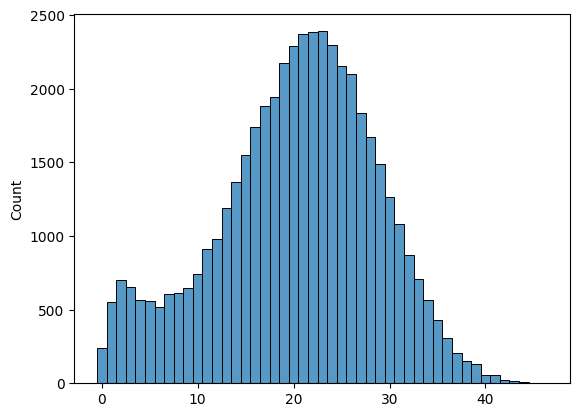

In [15]:
sizes = []
for t in trace:
    sizes.append(t.sum())

sns.histplot(sizes, discrete=True)

<Axes: ylabel='Count'>

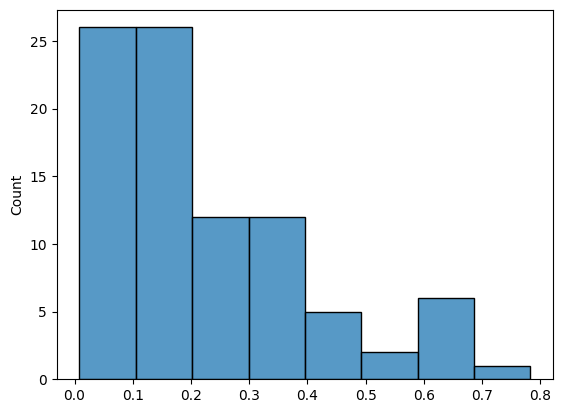

In [16]:
app = []
for i in trace.T:
    app.append(i.mean())

sns.histplot(app)

In [17]:
pd.set_option('display.max_rows', None)
print(p_sample[["aisle", "aisle_id"]].drop_duplicates())

                             aisle  aisle_id
0            prepared soups salads         1
1                specialty cheeses         2
2              energy granola bars         3
3                    instant foods         4
4       marinades meat preparation         5
5                            other         6
6                    packaged meat         7
7                  bakery desserts         8
8                      pasta sauce         9
10                kitchen supplies        10
11                cold flu allergy        11
12                     fresh pasta        12
13                  prepared meals        13
15          tofu meat alternatives        14
19                packaged seafood        15
20                     fresh herbs        16
21              baking ingredients        17
22    bulk dried fruits vegetables        18
23                   oils vinegars        19
24                    oral hygiene        20
29                 packaged cheese        21
30        